2024-08-17 02:17:46.122782
2004-08-17 02:17:46.122782


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


0.04409098905752986
0.09999705186806988
0.021787944043499853
0.05470458696236748
0.04691037456785035
0.10526080579230493
0.07172984309302194
0.12171406462016167
0.06394591563721144


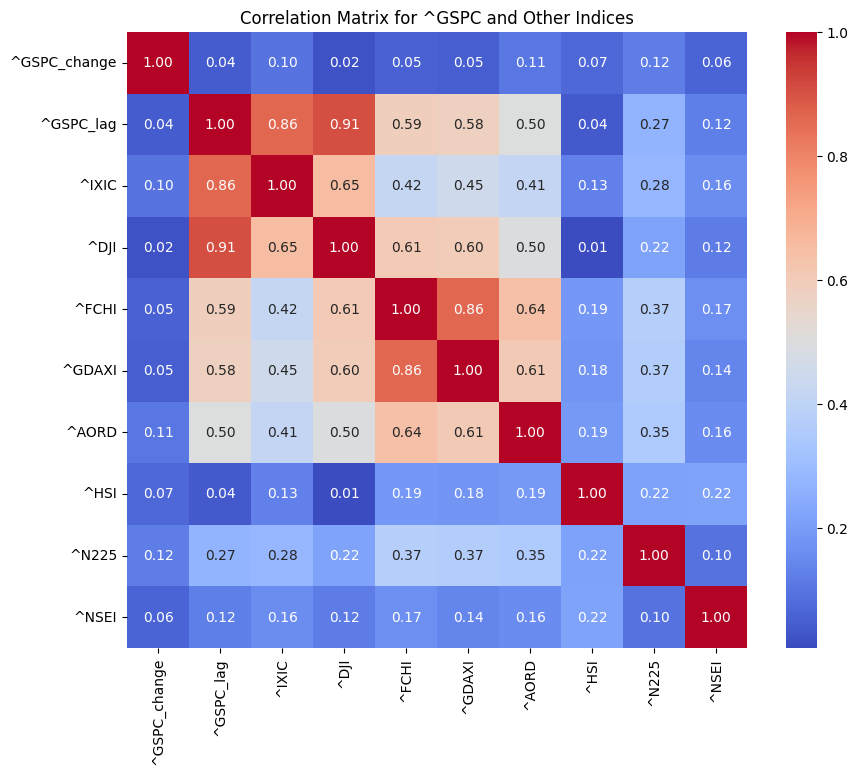

(51.42052124911951, 48.5325193707443)
(54.848555999060814, 45.10448462080301)
(50.55177271660014, 49.40126790326368)
(51.42052124911951, 48.5559990608124)
(51.678797839868515, 48.274242779995305)
(52.876262033341156, 46.959380136182205)
(53.46325428504344, 46.46630664475229)
(54.23808405729045, 45.71495656257337)
(53.5571730453158, 46.395867574548014)


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


(3407, 6)
      ^GSPC_lag       ^IXIC       ^AORD        ^HSI       ^N225       ^NSEI
3467   7.700195   93.889648  -13.000000   17.000000   63.410156   53.150391
3468  17.479980   43.540039   39.500000  285.550781  -71.121094   21.000000
3469  10.449707   17.000000   -6.100098  -98.189453  -64.640625 -100.649414
3470   8.310059   91.380859   -7.799805 -297.791016 -114.830078  -59.049805
3471  -2.560059    0.659180   19.500000 -279.951172 -104.781250  -55.400391
...         ...         ...         ...         ...         ...         ...
4254  37.219727  157.121094   37.799805    8.669922 -247.339844   26.949219
4255  25.100098  151.099609   13.700195   13.849609  741.933594 -203.349609
4256  65.379883  282.900391   28.000000 -120.320312  -93.171875  -40.650391
4257  58.770020  166.898438   13.599609  100.929688  345.242188  -40.650391
4258  29.370117 -166.939453  106.100098  144.121094  757.742188  206.300781

[792 rows x 6 columns]
(3407, 1)
(792, 1)


C:\Users\chuac\AppData\Local\Temp\ipykernel_3320\1172888756.py:6: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:281.)
  return torch.tensor(X, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)


torch.Size([3397, 10, 6])
torch.Size([3397, 1])
torch.Size([782, 10, 6])
torch.Size([782, 1])
Epoch [1/60], MSE: 1224.97, MAPE: 1.02
Epoch [2/60], MSE: 1220.55, MAPE: 1.03
Epoch [3/60], MSE: 1218.60, MAPE: 1.03
Epoch [4/60], MSE: 1212.12, MAPE: 1.04
Epoch [5/60], MSE: 1177.33, MAPE: 1.04
Epoch [6/60], MSE: 1142.58, MAPE: 1.02
Epoch [7/60], MSE: 1207.95, MAPE: 1.07
Epoch [8/60], MSE: 1190.92, MAPE: 1.05
Epoch [9/60], MSE: 1166.03, MAPE: 0.87
Epoch [10/60], MSE: 1238.20, MAPE: 0.97
Epoch [11/60], MSE: 1224.29, MAPE: 1.02
Epoch [12/60], MSE: 1220.83, MAPE: 1.03
Epoch [13/60], MSE: 1216.56, MAPE: 1.03
Epoch [14/60], MSE: 1205.16, MAPE: 1.03
Epoch [15/60], MSE: 1198.24, MAPE: 1.03
Epoch [16/60], MSE: 1163.62, MAPE: 1.03
Epoch [17/60], MSE: 1185.96, MAPE: 1.05
Epoch [18/60], MSE: 1112.56, MAPE: 1.02
Epoch [19/60], MSE: 1211.22, MAPE: 1.08
Epoch [20/60], MSE: 1211.25, MAPE: 1.06
Epoch [21/60], MSE: 1088.88, MAPE: 0.98
Epoch [22/60], MSE: 1178.69, MAPE: 1.03
Epoch [23/60], MSE: 1089.20, MAPE: 

In [2]:
%run Predictions.ipynb

In [3]:
import numpy as np

### Final Model Predictions on entire Dataset

In [4]:
predictions_tensors = torch.cat(predictions, dim=0)
predictions_list = predictions_tensors.flatten().tolist()

In [5]:
calc_profit_df = final_df[['Date', f'{target_stock}_change', 'Price', 'Close']].iloc[test_index:]
calc_profit_df_top10 = calc_profit_df.iloc[:10]
calc_profit_df_bot10 = calc_profit_df.iloc[10:].reset_index(drop=True)
calc_profit_df_top10['Predicted_Gain'] = np.nan
calc_profit_df_bot10['Predicted_Gain'] = pd.DataFrame(predictions_list, columns=['Predicted_Gain'])
calc_profit_df = pd.concat([calc_profit_df_top10, calc_profit_df_bot10])
# print(calc_profit_df)

C:\Users\chuac\AppData\Local\Temp\ipykernel_3320\3061616727.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  calc_profit_df_top10['Predicted_Gain'] = np.nan


In [6]:
# Percentage of predictions that are in the same direction as change in stock price
right_direction = 0
total = 0
for _, row in calc_profit_df.iterrows():
    change = row[f'{target_stock}_change']
    predict = row['Predicted_Gain']
    if (change < 0 and predict <0) or (change > 0 and predict > 0):
        right_direction += 1
    total += 1
print(right_direction/total*100) 

49.11616161616162


In [7]:
# Utilise Bollinger Bands to gauge trend and decide on whether to long or short
def calc_profit(data):
    # Applying Bollinger Bands with Exponential Moving Average
    window = 20  
    data['EMA'] = data['Price'].ewm(span=window, adjust=True).mean()
    data['STD'] = data['Price'].rolling(window=window).std()
    data['Upper_Band'] = data['EMA'] + (2 * data['STD'])
    data['Lower_Band'] = data['EMA'] - (2 * data['STD'])
    data.dropna(inplace=True, ignore_index=True)
    
    # Decide on whether to short or long the stock
    orders = []
    for _, row in data.iterrows():
        if row['Price'] > row['Upper_Band']:
            orders.append(-1)
        elif row['Price'] < row['Lower_Band']:
            orders.append(1)
        elif row['Predicted_Gain'] > 0:
            orders.append(1)
        elif row['Predicted_Gain'] < 0:
            orders.append(-1) 
    
    data['Order'] = pd.DataFrame(orders, columns=['Order'])
     
    data['Profit Per Trade'] = data[f'{target_stock}_change'] * data['Order']
    data['Cumulative Profit'] = data['Profit Per Trade'].cumsum()
    data['Hold'] = data[f'{target_stock}_change'].cumsum()
    return data

In [8]:
final_df = calc_profit(calc_profit_df)

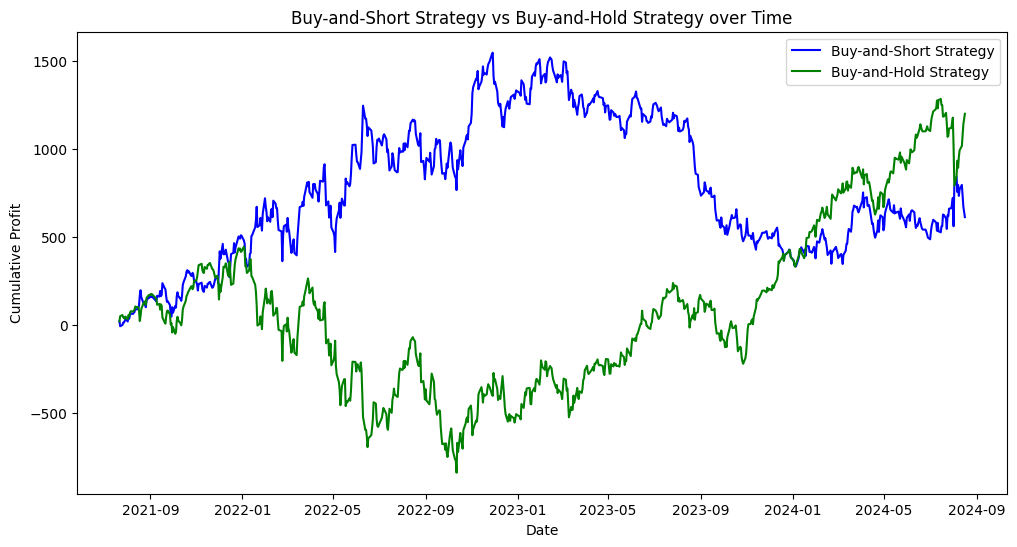

In [10]:
plt.figure(figsize=(12, 6))

plt.plot(final_df['Date'], final_df['Cumulative Profit'], label='Buy-and-Short Strategy', color='blue')
plt.plot(final_df['Date'], final_df['Hold'], label='Buy-and-Hold Strategy', color='green')

plt.title('Buy-and-Short Strategy vs Buy-and-Hold Strategy over Time')
plt.xlabel('Date')
plt.ylabel('Cumulative Profit')
plt.legend()
plt.show()